
# Mini Project 2 —  **Futures** & **Options on Futures**

This simple notebook explores **futures** and **European options on futures** using the classic **Black–76** model.
We keep everything lightweight and well-commented.

**You will:**
- Compute **theoretical futures price** via cost-of-carry.
- Price **European calls/puts on futures** with **Black–76**.
- (Optional) Infer **implied volatility** by inverting Black–76.
- Do a tiny **hedging with futures** demo: compare unhedged vs hedged P&L for a stock exposure.



## 1) Background: Futures, Cost-of-Carry

**Futures price** under continuous carry (risk-free rate \(r\) and dividend yield \(q\)) is

$$
F_0 \;=\; S_0 \, e^{(r - q)T}\,.
$$

**Options on futures** (European) are commonly priced with **Black–76**:

Let

$$
d_1 \;=\; \frac{\ln\!\left(\frac{F_0}{K}\right) \;+\; \tfrac{1}{2}\sigma^2 T}{\sigma \sqrt{T}},
\qquad
d_2 \;=\; d_1 - \sigma \sqrt{T}.
$$

Then the **call** and **put** prices are

$$
C \;=\; e^{-rT}\,\big( F_0\,N(d_1) - K\,N(d_2) \big), \qquad
P \;=\; e^{-rT}\,\big( K\,N(-d_2) - F_0\,N(-d_1) \big).
$$



## 2) Setup


In [2]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
np.random.seed(1)



## 3) (Optional) Load CSV to Estimate Volatility

If you have a CSV with columns `Date` and `Close` (or `Adj Close`), set the path below.
We estimate **annualized volatility** as

$$
\hat{\sigma} \;=\; \operatorname{stdev}(\Delta \log S)\,\sqrt{252}\,.
$$

If not, we use a default \(\sigma\).


In [3]:

DATA_CSV_PATH = "/mnt/data/your_price_data.csv"  # <- change if you have data
DEFAULT_SIGMA = 0.20

def load_price_series(path):
    try:
        df = pd.read_csv(path)
        price_col = None
        for c in ["Adj Close","AdjClose","Close","close","Price","price"]:
            if c in df.columns:
                price_col = c
                break
        if price_col is None:
            return None
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"])
            df = df.sort_values("Date")
        s = pd.Series(df[price_col].values, index=df.get("Date", pd.RangeIndex(len(df)))).dropna()
        s = s[s > 0]
        return s if len(s) > 50 else None
    except Exception:
        return None

price_series = load_price_series(DATA_CSV_PATH)
if price_series is not None:
    logret = np.log(price_series).diff().dropna().values
    sigma_hat = np.std(logret) * np.sqrt(252.0)
    print(f"Loaded CSV. Estimated annualized sigma ≈ {sigma_hat:.4f}")
else:
    sigma_hat = DEFAULT_SIGMA
    print(f"No CSV found. Using DEFAULT_SIGMA = {sigma_hat:.2f}")


No CSV found. Using DEFAULT_SIGMA = 0.20



## 4) Futures Pricing (Cost-of-Carry)

Under continuous carry with rate \(r\) and dividend yield \(q\), the **theoretical futures price** is

$$
F_0 \;=\; S_0 \, e^{(r - q)T}\,.
$$

We wrap this in a small helper.


In [4]:

def futures_price_carry(S0, r, q, T):
    """
    Cost-of-carry futures price:
      F0 = S0 * exp((r - q) * T)
    """
    return float(S0 * math.exp((r - q) * T))

# quick test
print("F0 (S0=100, r=3%, q=0, T=0.5) =", futures_price_carry(100, 0.03, 0.0, 0.5))


F0 (S0=100, r=3%, q=0, T=0.5) = 101.51130646157189



## 5) Black–76 Pricing (Options on Futures)

We implement \(N(x)\) (normal CDF) and the Black–76 formulas for calls and puts:

$$
C \;=\; e^{-rT}\,\big( F_0\,N(d_1) - K\,N(d_2) \big), \qquad
P \;=\; e^{-rT}\,\big( K\,N(-d_2) - F_0\,N(-d_1) \big).
$$


In [5]:

from math import erf

def N(x):
    # Standard normal CDF via erf
    return 0.5 * (1.0 + erf(x / math.sqrt(2.0)))

def black76_price(F0, K, r, sigma, T, is_call=True):
    """
    European option on futures (Black-76).
    """
    if T <= 0 or sigma <= 0 or F0 <= 0 or K <= 0:
        # intrinsic at expiry (discounted zero because it's instant),
        # but in practice we call only with T>0.
        if is_call:
            return max(0.0, F0 - K) * math.exp(-r*T)
        else:
            return max(0.0, K - F0) * math.exp(-r*T)

    d1 = (math.log(F0/K) + 0.5 * sigma * sigma * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if is_call:
        return math.exp(-r*T) * (F0 * N(d1) - K * N(d2))
    else:
        return math.exp(-r*T) * (K * N(-d2) - F0 * N(-d1))

# quick sample
F0 = futures_price_carry(100, 0.03, 0.0, 0.5)
print("Black-76 call, F0≈", round(F0,2), ":", round(black76_price(F0, 100, 0.03, 0.25, 0.5, True), 4))


Black-76 call, F0≈ 101.51 : 7.7603



## 6) Implied Volatility (Black–76)

Given a market price \(V^{mkt}\), solve for \(\sigma\) in \(V^{model}(\sigma) = V^{mkt}\) via **bisection**.


In [6]:

def b76_implied_vol(target_price, F0, K, r, T, is_call=True, tol=1e-8, max_iter=100):
    """
    Bisection implied vol for Black-76.
    """
    lo, hi = 1e-9, 5.0
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        p = black76_price(F0, K, r, mid, T, is_call)
        if abs(p - target_price) < tol:
            return mid
        if p > target_price:
            hi = mid
        else:
            lo = mid
    return 0.5*(lo+hi)

# small test: use model price, recover sigma
price_target = black76_price(F0, 100, 0.03, 0.25, 0.5, True)
iv_back = b76_implied_vol(price_target, F0, 100, 0.03, 0.5, True)
print("Implied vol back-out (should be close to 0.25):", round(iv_back, 4))


Implied vol back-out (should be close to 0.25): 0.25



## 7) Examples (Price Curves)

We draw **Black–76** call and put prices across strikes.


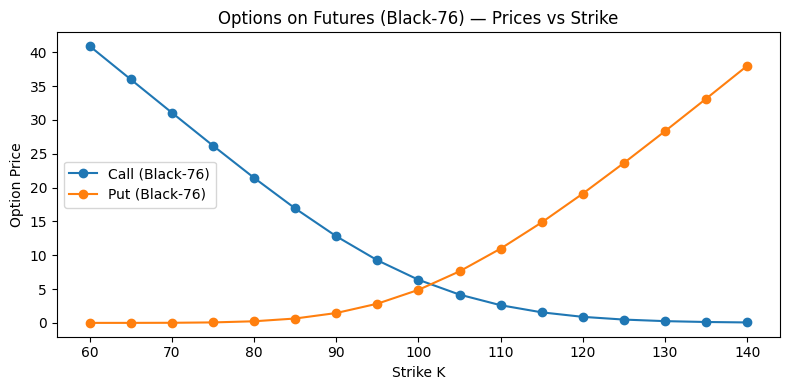

In [7]:

# Set a scenario
S0 = 100.0
r, q, T = 0.03, 0.00, 0.5   # 6 months
sigma = float(sigma_hat)

F0 = futures_price_carry(S0, r, q, T)
strikes = np.linspace(60, 140, 17)

calls, puts = [], []
for K in strikes:
    calls.append(black76_price(F0, K, r, sigma, T, is_call=True))
    puts.append(black76_price(F0, K, r, sigma, T, is_call=False))

plt.figure()
plt.plot(strikes, calls, marker='o', label="Call (Black-76)")
plt.plot(strikes, puts,  marker='o', label="Put (Black-76)")
plt.title("Options on Futures (Black-76) — Prices vs Strike")
plt.xlabel("Strike K")
plt.ylabel("Option Price")
plt.legend()
plt.tight_layout()
plt.show()



## 8) Tiny Hedging with Futures (1-step P&L)

Suppose you hold $n$ shares of stock. You **short** $n$ futures (contract size $=1$) to hedge.
Over a small step $\Delta t$ (1 day), stock moves from $S_0$ to $S_1=S_0+\Delta S$.

We approximate the 1-day futures price update by cost-of-carry:

$$
F_0 \;=\; S_0 e^{(r-q)T}, \qquad
F_1 \;=\; S_1 e^{(r-q)(T-\Delta t)}.
$$

**Unhedged P\&L**: $ n\cdot\Delta S $.  
**Hedged P\&L**: $ n\cdot\Delta S \;-\; n\cdot(F_1 - F_0) $.


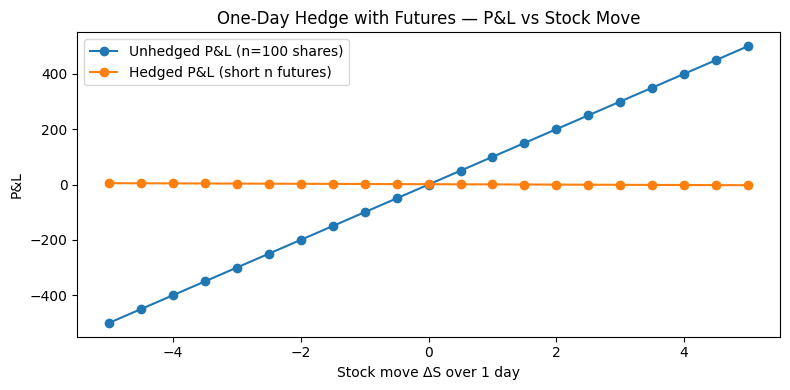

In [7]:

def one_day_hedge_pnl(S0, dS, n=100, r=0.03, q=0.0, T=0.25, dt=1/252):
    """
    Compare unhedged vs futures-hedged P&L for n shares over one day.
    Futures contract size is 1 for simplicity; hedge uses n contracts.
    """
    F0 = futures_price_carry(S0, r, q, T)
    S1 = S0 + dS
    F1 = futures_price_carry(S1, r, q, max(T - dt, 0))
    pnl_unhedged = n * (S1 - S0)
    pnl_hedged   = pnl_unhedged - n * (F1 - F0)
    return F0, F1, pnl_unhedged, pnl_hedged

S0 = 100.0
T  = 0.25
dS_values = np.linspace(-5, 5, 21)
unhedged, hedged = [], []
for dS in dS_values:
    _, _, pu, ph = one_day_hedge_pnl(S0, dS, n=100, r=0.03, q=0.0, T=T, dt=1/252)
    unhedged.append(pu)
    hedged.append(ph)

plt.figure()
plt.plot(dS_values, unhedged, marker='o', label="Unhedged P&L (n=100 shares)")
plt.plot(dS_values, hedged,   marker='o', label="Hedged P&L (short n futures)")
plt.title("One-Day Hedge with Futures — P&L vs Stock Move")
plt.xlabel("Stock move ΔS over 1 day")
plt.ylabel("P&L")
plt.legend()
plt.tight_layout()
plt.show()
